# Market Price Analysis

This notebook analyzes prices from large markets in Ulaanbaatar, Mongolia from 2012-2021.

Questions I've identified:

- What markets are most/least expensive consistently?
- How did COVID impact prices?
- Is there a sign of price anchoring?

In [47]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [75]:
plt.style.use('../mds.mplstyle')
pd.set_option('display.max_rows', 1000)

In [12]:
df = pd.read_csv("data/prices_en.csv")

In [13]:
df.dtypes

date        object
product     object
market      object
size        object
price      float64
dtype: object

In [14]:
df.head()

,date,product,market,size,price
0,2019-01-02,Aleika High Grade Flour,Bars,kg,NaN
1,2019-01-02,Aleika High Grade Flour,Bayanzurkh,kg,NaN
2,2019-01-02,Aleika High Grade Flour,Bumbugur,kg,NaN
3,2019-01-02,Aleika High Grade Flour,Emart,kg,NaN
4,2019-01-02,Aleika High Grade Flour,Kharkhorin,kg,NaN


## Data Cleaning

Change date to a datetime and sort so we can see the date range for our data.

In [15]:
df['date'] = pd.to_datetime(df['date'])

In [16]:
df = df.sort_values(by='date').reset_index(drop=True)

In [17]:
df.head()

,date,product,market,size,price
0,2019-01-02,Aleika High Grade Flour,Bars,kg,NaN
1,2019-01-02,Mutton w/Bones,Max/M Mart,kg,6950.0
2,2019-01-02,Mutton w/Bones,Khuchit Shonkhor,kg,6500.0
3,2019-01-02,Mutton w/Bones,Kharkhorin,kg,6000.0
4,2019-01-02,Mutton w/Bones,Emart,kg,6900.0


In [18]:
df.tail()

,date,product,market,size,price
61095,2021-11-24,"Beet, Mongolian",Bumbugur,kg,4000.0
61096,2021-11-24,"Beet, Mongolian",Bayanzurkh,kg,3500.0
61097,2021-11-24,"Beet, Mongolian",Bars,kg,4500.0
61098,2021-11-24,"Egg, Russian",Saruul,each,420.0
61099,2021-11-24,Yogurt,Tavan Erdene,liter,3000.0


Let's translate our names so we can more easily read them.

In [19]:
df.dtypes

date       datetime64[ns]
product            object
market             object
size               object
price             float64
dtype: object

In [20]:
df.sample(2)

,date,product,market,size,price
26282,2020-04-29,"Gree Tea, Georgia",Bayanzurkh,kg,1500.0
48121,2021-04-14,"Butter, Suu LTD",Kharkhorin,kg,NaN


## 0. Which markets have which products?

First we should determine which markets regularly carry each product. Because we have a large number of products and markets we could perhaps build a heatmap.

In [21]:
df.shape

(61100, 5)

In [22]:
df['product'].unique()

array(['Aleika High Grade Flour', 'Mutton w/Bones', 'Mutton Boneless',
       'Milk, Bulk', 'Potato, Mongolian', 'Onion, China',
       'Gree Tea, Georgia', 'Goat Meat w/Bones', 'Egg, Russian',
       'Horse Meat w/Bones', 'White Rice', 'Vegatable Oil', 'Yellow Rice',
       'Yogurt', 'Suu Brand Milk, 1l', 'Sugar',
       'Round Bread, Czech Style', 'Suu Brand Milk, 0.5l',
       'Altan Taria Packaged Flour, High Grade',
       'Altan Taria Packaged Flour, 2nd Grade',
       'Altan Taria Packaged Flour, Top Grade', 'Atar Brand Bread',
       'Apple, Fuji', 'Altan Taria Packaged Flour, 1st Grade',
       'Altan Taria Flour, First Grade', 'Altan Taria Flour, High Grade',
       'Cabbage, Mongolian', 'Butter, Suu LTD', 'Brown Bread',
       'Carrot, Mongolian', 'Beef w/Bones', 'Beef Boneless',
       'Beet, Mongolian', 'Reserve meat, beef w/bones',
       'Reserve meat, goat w/bones', 'Reserve meat, mutton w/bones'],
      dtype=object)

In [23]:
heatmap = (df.
           groupby(by=['market','product'])
           .count()
           .reset_index()
           .pivot(index='market', columns='product', values='price') 
           / len(df['date'].unique()))

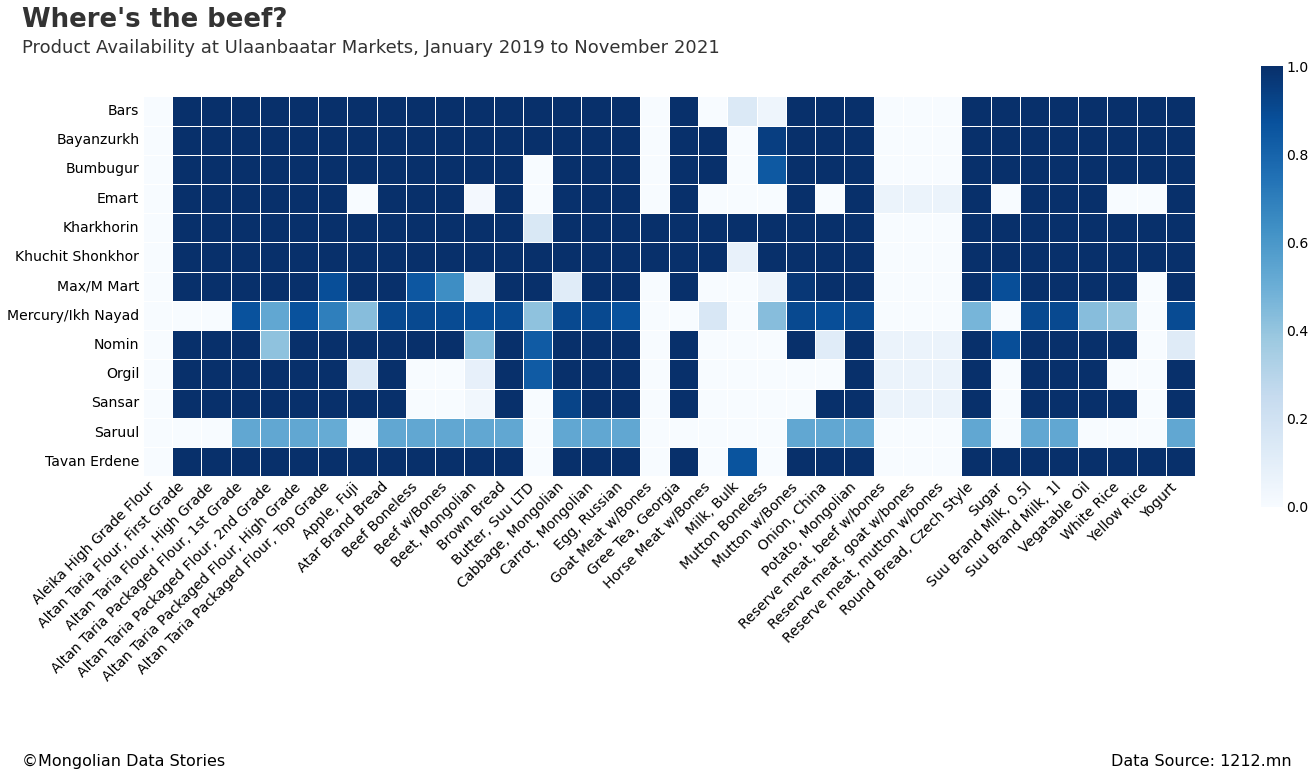

In [24]:
fig, ax = plt.subplots(figsize=(21,9))
sns.heatmap(heatmap, ax=ax, cmap='Blues', linewidths=0.5, square=True)

# This nice trick works with text and dates. 
fig.autofmt_xdate(rotation=45)

# Remove axis labels
ax.set_ylabel('')    
ax.set_xlabel('')

# Set title and subtitle
ax.text(x=0, y=.94, s="Where's the beef?", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=0, y=.90, s="Product Availability at Ulaanbaatar Markets, January 2019 to November 2021", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = 0, y = -.2, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16, )
ax.text(x = .84, y = -.2, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/product_availability.png', dpi = 300, bbox_inches="tight")

## 1. What markets are most/least expensive consistently?

Of course the first question on most people's mind is, which markets have the most or least expensive products? There are several products that are very similar, such as different types of flour, that make the analysis a bit complicated. To make things simpler I will choose a few products that are very common:

To show this I will build a plot for each product, comparing prices for each product.

In [25]:
np.sort(df['product'].unique())

array(['Aleika High Grade Flour', 'Altan Taria Flour, First Grade',
       'Altan Taria Flour, High Grade',
       'Altan Taria Packaged Flour, 1st Grade',
       'Altan Taria Packaged Flour, 2nd Grade',
       'Altan Taria Packaged Flour, High Grade',
       'Altan Taria Packaged Flour, Top Grade', 'Apple, Fuji',
       'Atar Brand Bread', 'Beef Boneless', 'Beef w/Bones',
       'Beet, Mongolian', 'Brown Bread', 'Butter, Suu LTD',
       'Cabbage, Mongolian', 'Carrot, Mongolian', 'Egg, Russian',
       'Goat Meat w/Bones', 'Gree Tea, Georgia', 'Horse Meat w/Bones',
       'Milk, Bulk', 'Mutton Boneless', 'Mutton w/Bones', 'Onion, China',
       'Potato, Mongolian', 'Reserve meat, beef w/bones',
       'Reserve meat, goat w/bones', 'Reserve meat, mutton w/bones',
       'Round Bread, Czech Style', 'Sugar', 'Suu Brand Milk, 0.5l',
       'Suu Brand Milk, 1l', 'Vegatable Oil', 'White Rice', 'Yellow Rice',
       'Yogurt'], dtype=object)

In [26]:
product_list = ['Suu Brand Milk, 1l',
                'Egg, Russian',
                'Potato, Mongolian',
                'Carrot, Mongolian',
                'White Rice',
                'Atar Brand Bread', 
                'Beef w/Bones',
                'Mutton w/Bones']

In [27]:
product_list

['Suu Brand Milk, 1l',
 'Egg, Russian',
 'Potato, Mongolian',
 'Carrot, Mongolian',
 'White Rice',
 'Atar Brand Bread',
 'Beef w/Bones',
 'Mutton w/Bones']

### Failed attempt to make an easy to read line plot

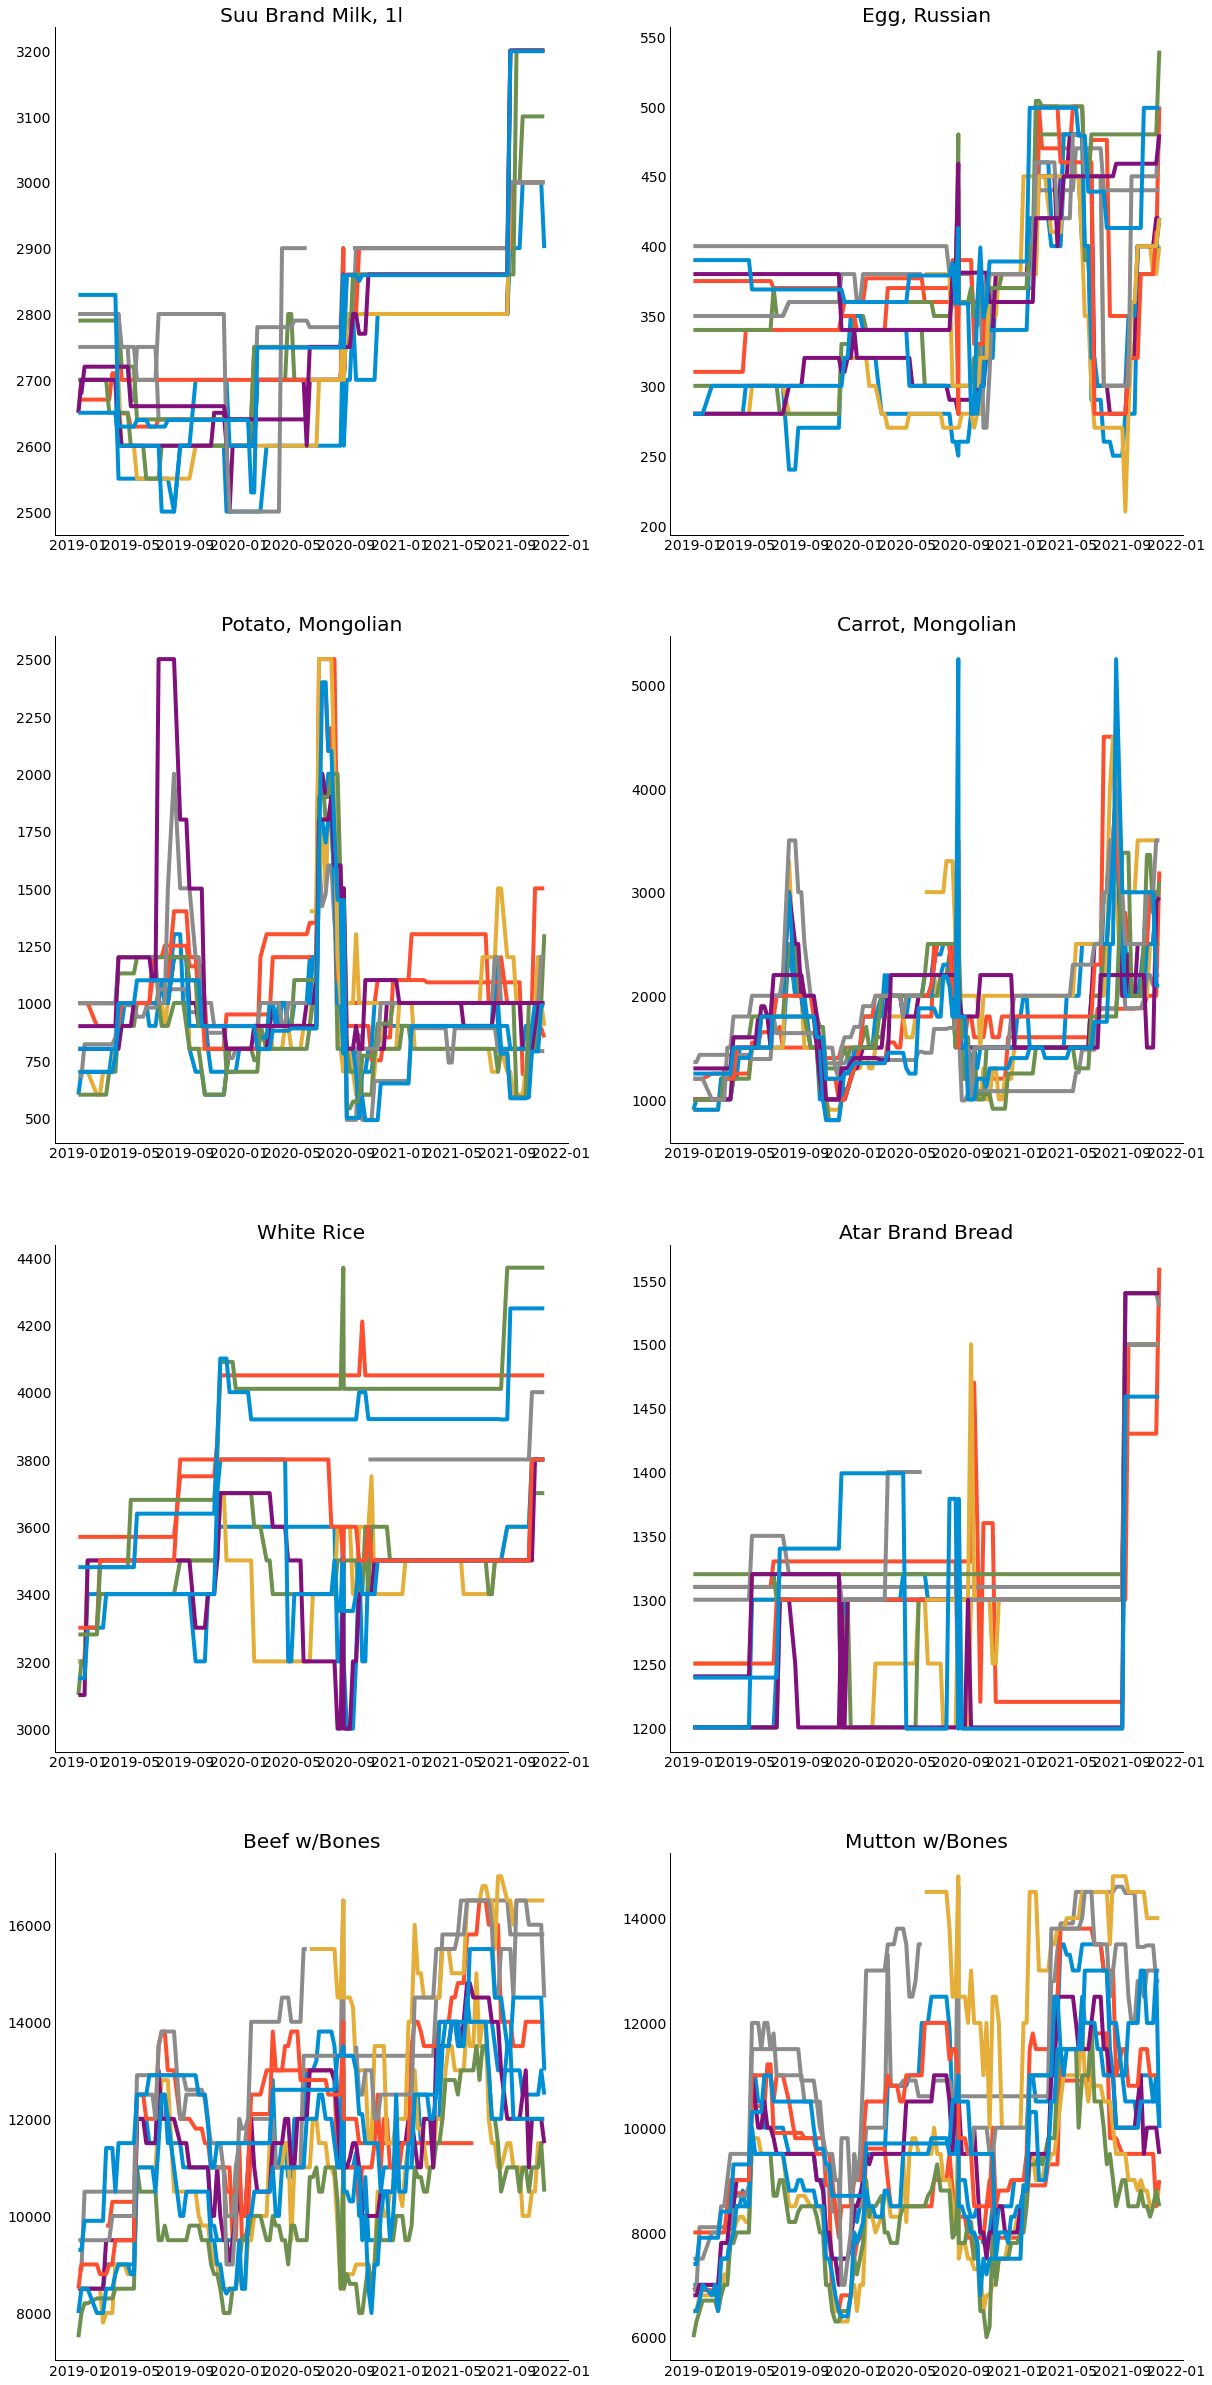

In [28]:
fig, axs = plt.subplots(4, 2, figsize=(18,40))

# The plot now is missing tick labels on the subplots. Let's add them back.
for ax in fig.axes:
    # Add missing tick labels
    ax.tick_params(axis='both', which='major', bottom=True, left=True, labelbottom=True,  labelleft=True)
    # Set xlim and ylim
    #ax.set_ylim(0, round(filtered_df['price'].max(), -3))
    #ax.set_xlim(filtered_df['date'].min(), filtered_df['date'].max())


# Loop through products to make the plots  
for product, ax in zip(product_list, fig.axes):
    for market in df['market'].unique():
        x = df[(df['market'] == market) & (df['product'] == product)]['date']
        y = df[(df['market'] == market) & (df['product'] == product)]['price']
        ax.plot(x, y, label=market)
        ax.title.set_text(product)
        
# Set legend for entire plot
#lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(labels);

# Save image
#plt.savefig('images/product_timeseries.png', dpi = 300, bbox_inches="tight")

Well this isn't as clear as I hoped. The prices mix around quite a lot between the markets. There is a clear difference between the high and low end of the market, but there is also a lot of price crossover. 

Let's take a different approach and instead make a plot for each product individually so we can see more of what is happening. Instead of showing the time series I will take two dates, one from 2019 and one from 2021 and show the change. We will use a dumbell plot as this can show the change with less noise.

### Сүү ХК 1л - Suu Brand Milk, 1L

In [29]:
df['market'].unique()

array(['Bars', 'Max/M Mart', 'Khuchit Shonkhor', 'Kharkhorin', 'Emart',
       'Bumbugur', 'Bayanzurkh', 'Tavan Erdene', 'Saruul', 'Sansar',
       'Mercury/Ikh Nayad', 'Orgil', 'Nomin'], dtype=object)

In [30]:
market_order = {'Khuchit Shonkhor':0, 'Kharkhorin':1, 'Bars':2 , 'Bayanzurkh': 3, 
                'Bumbugur': 4,  'Tavan Erdene': 5, 'Mercury/Ikh Nayad': 6, 'Ikh Nayad': 7, 
                'Saruul': 8, 'Sansar': 9, 'Emart': 10, 'Max/M Mart': 11, 'Nomin': 12, 'Orgil': 13}

/var/folders/h6/t5s_1mjx40z0hhvtvsf11xf00000gn/T/ipykernel_6525/3896227401.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(product_df.index, ha = 'left')


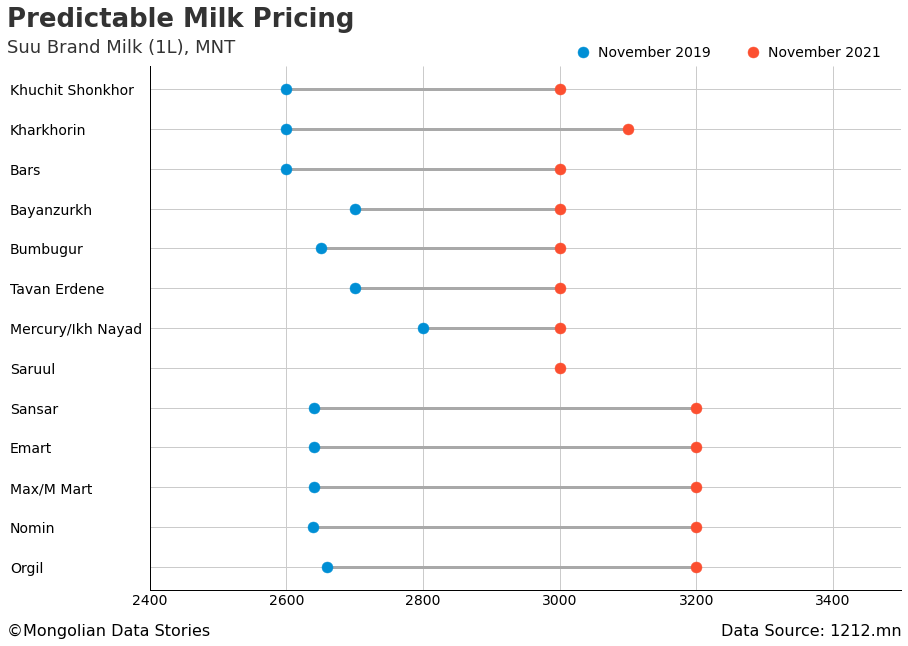

In [31]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Suu Brand Milk, 1l'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Realign y-axis labels
ax.set_xlim(2400, 3500)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Predictable Milk Pricing", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="Suu Brand Milk (1L), MNT", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/milk_dumbell.png', dpi = 300, bbox_inches="tight")

### Өндөг, ОХУ - Russian Eggs

/var/folders/h6/t5s_1mjx40z0hhvtvsf11xf00000gn/T/ipykernel_6525/187593876.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(product_df.index, ha = 'left')


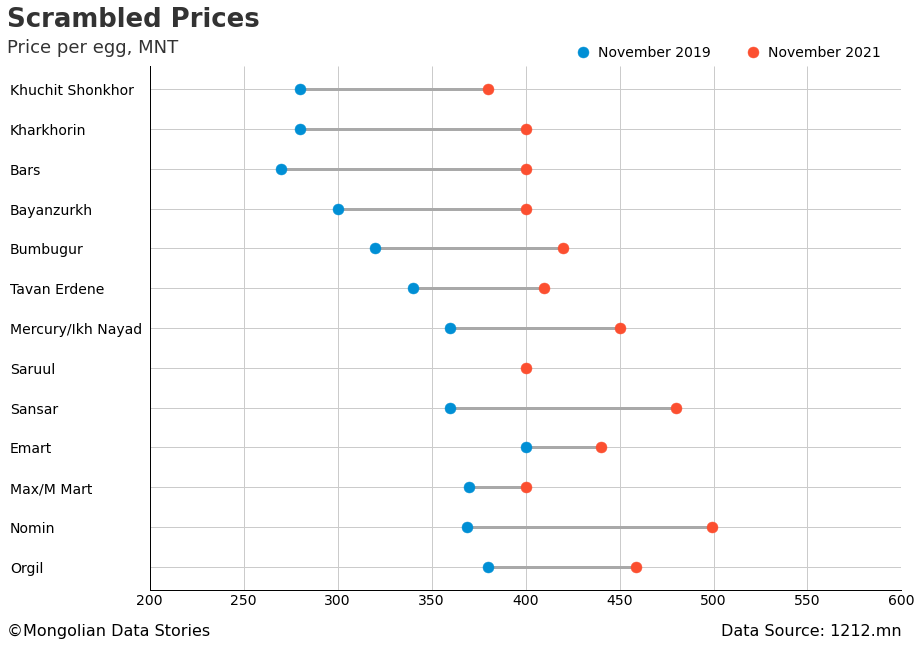

In [32]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Egg, Russian'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Realign y-axis labels
ax.set_xlim(200, 600)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Scrambled Prices", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="Price per egg, MNT", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/eggs_dumbell.png', dpi = 300, bbox_inches="tight")

### Төмс, монгол - Mongolian Potatos

/var/folders/h6/t5s_1mjx40z0hhvtvsf11xf00000gn/T/ipykernel_6525/1330134897.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(product_df.index, ha = 'left')


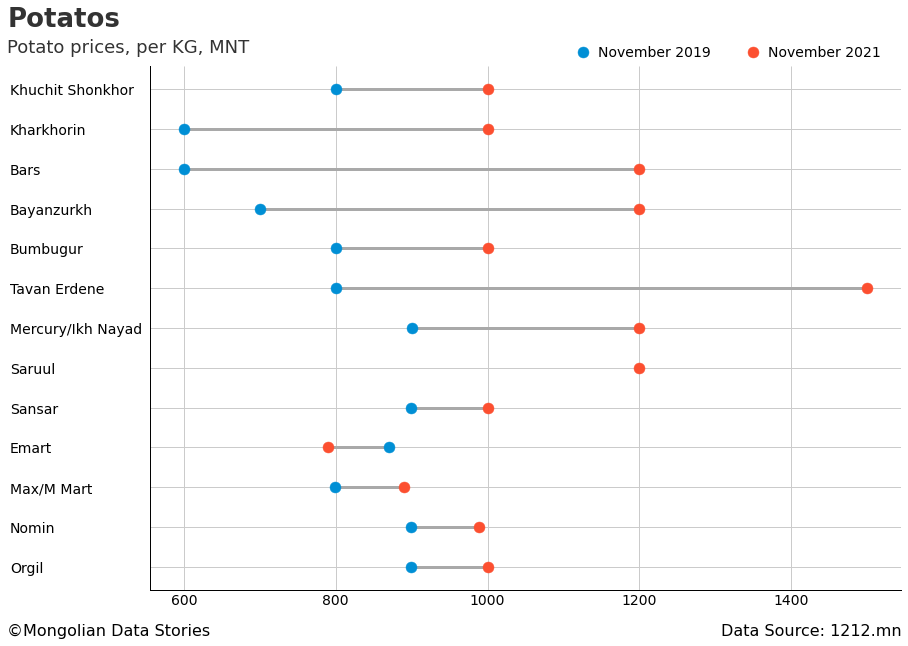

In [33]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Potato, Mongolian'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Realign y-axis labels
#ax.set_xlim(200, 600)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Potatos", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="Potato prices, per KG, MNT", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/potato_dumbell.png', dpi = 300, bbox_inches="tight")

### Лууван, монгол - Carrots, Mongolian

/var/folders/h6/t5s_1mjx40z0hhvtvsf11xf00000gn/T/ipykernel_6525/504967485.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(product_df.index, ha = 'left')


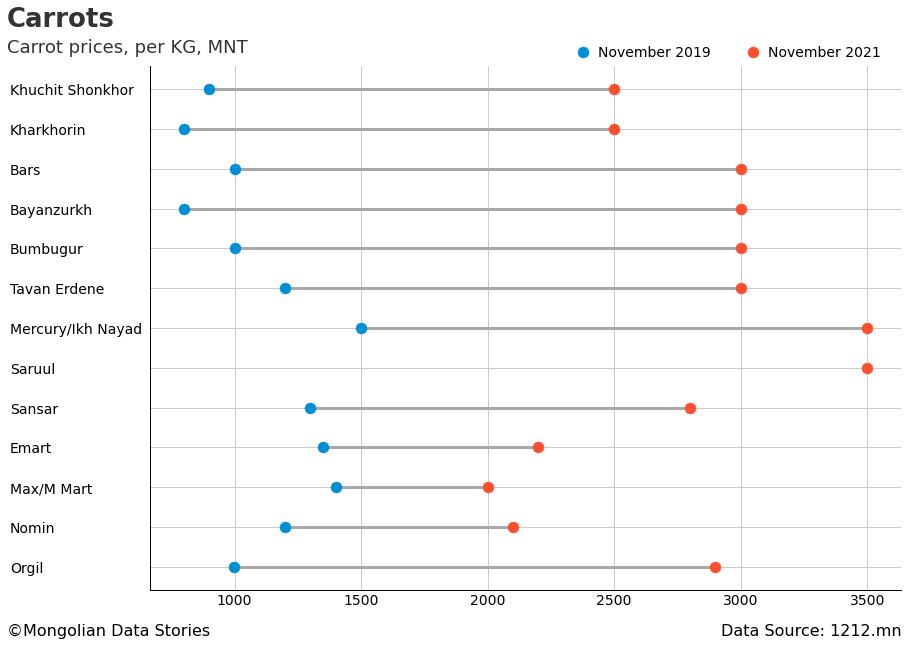

In [34]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Carrot, Mongolian'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Realign y-axis labels
#ax.set_xlim(200, 600)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Carrots", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="Carrot prices, per KG, MNT", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/carrots_dumbell.png', dpi = 300, bbox_inches="tight")

### Будаа цагаан - White Rice

/var/folders/h6/t5s_1mjx40z0hhvtvsf11xf00000gn/T/ipykernel_6525/2042430619.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(product_df.index, ha = 'left')


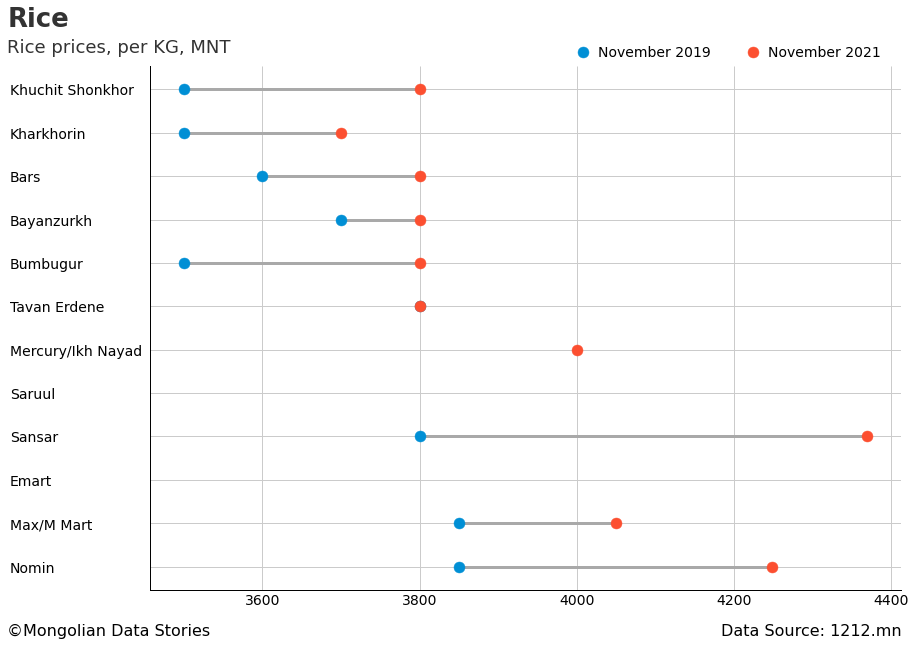

In [35]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'White Rice'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Realign y-axis labels
#ax.set_xlim(200, 600)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Rice", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="Rice prices, per KG, MNT", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/rice_dumbell.png', dpi = 300, bbox_inches="tight")

### Талх Атар - Atar Brand Bread

/var/folders/h6/t5s_1mjx40z0hhvtvsf11xf00000gn/T/ipykernel_6525/4064141654.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(product_df.index, ha = 'left')


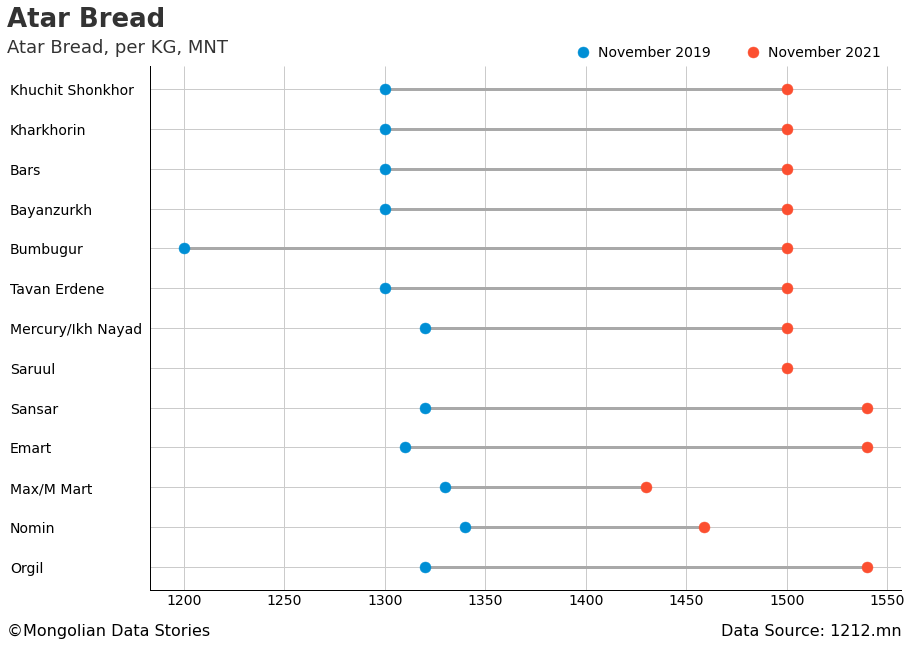

In [36]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Atar Brand Bread'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Realign y-axis labels
#ax.set_xlim(200, 600)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Atar Bread", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="Atar Bread, per KG, MNT", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/bread_dumbell.png', dpi = 300, bbox_inches="tight")

### Үхрийн мах ястай - Beef with Bones

/var/folders/h6/t5s_1mjx40z0hhvtvsf11xf00000gn/T/ipykernel_6525/2502414116.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(product_df.index, ha = 'left')


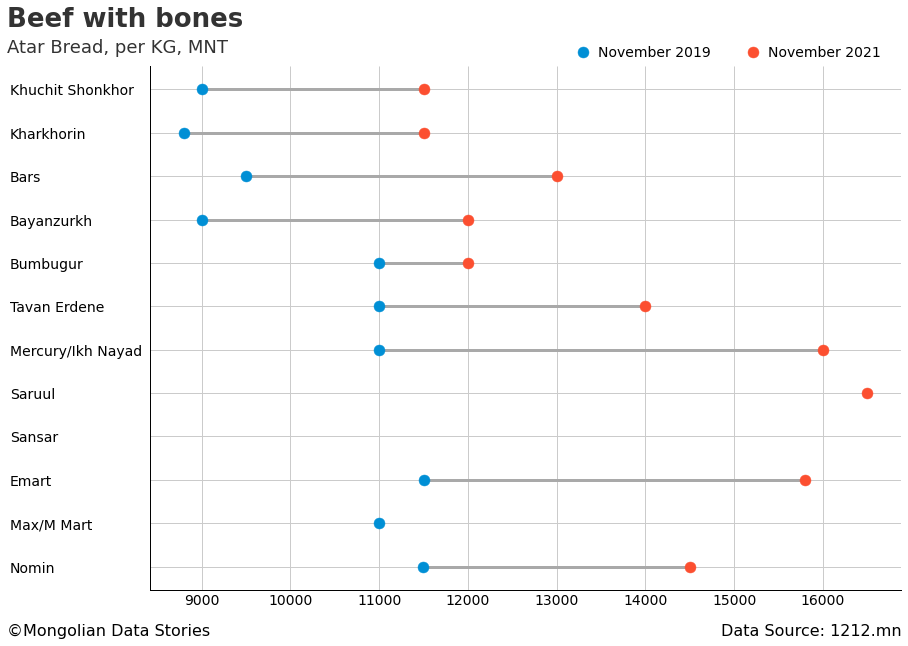

In [37]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Beef w/Bones'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Realign y-axis labels
#ax.set_xlim(200, 600)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Beef with bones", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="Atar Bread, per KG, MNT", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/beef_dumbell.png', dpi = 300, bbox_inches="tight")

### Хонины мах ястай - Mutton with Bones

/var/folders/h6/t5s_1mjx40z0hhvtvsf11xf00000gn/T/ipykernel_6525/587470166.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(product_df.index, ha = 'left')


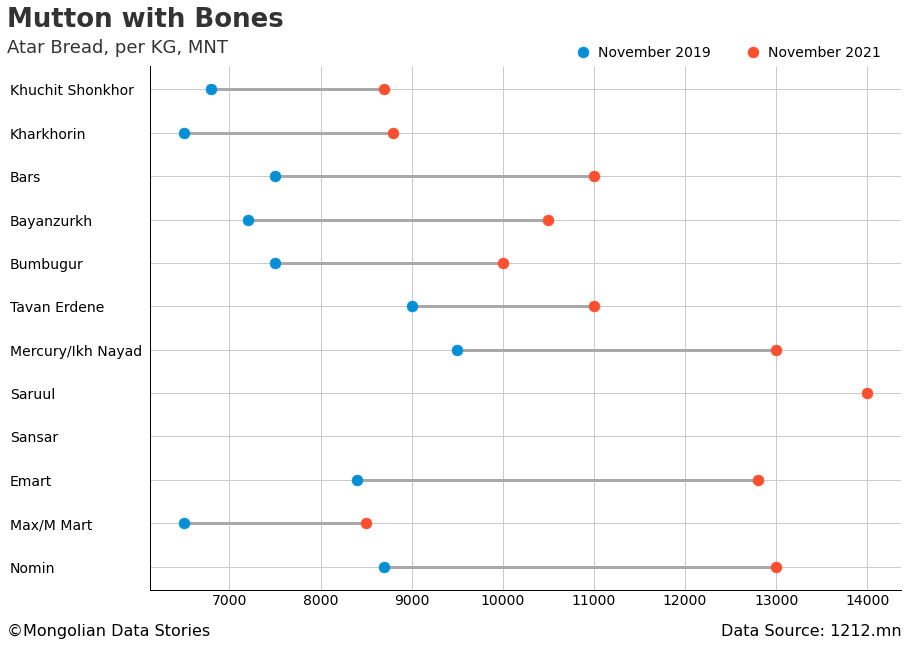

In [38]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Mutton w/Bones'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Realign y-axis labels
#ax.set_xlim(200, 600)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Mutton with Bones", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="Atar Bread, per KG, MNT", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/beef_dumbell.png', dpi = 300, bbox_inches="tight")

## 2. How did COVID impact prices?

In [39]:
product_list

['Suu Brand Milk, 1l',
 'Egg, Russian',
 'Potato, Mongolian',
 'Carrot, Mongolian',
 'White Rice',
 'Atar Brand Bread',
 'Beef w/Bones',
 'Mutton w/Bones']

In [40]:
avg_df = df[df['product'].isin(product_list)].groupby(by=['product', 'date'], dropna=True).mean().reset_index()

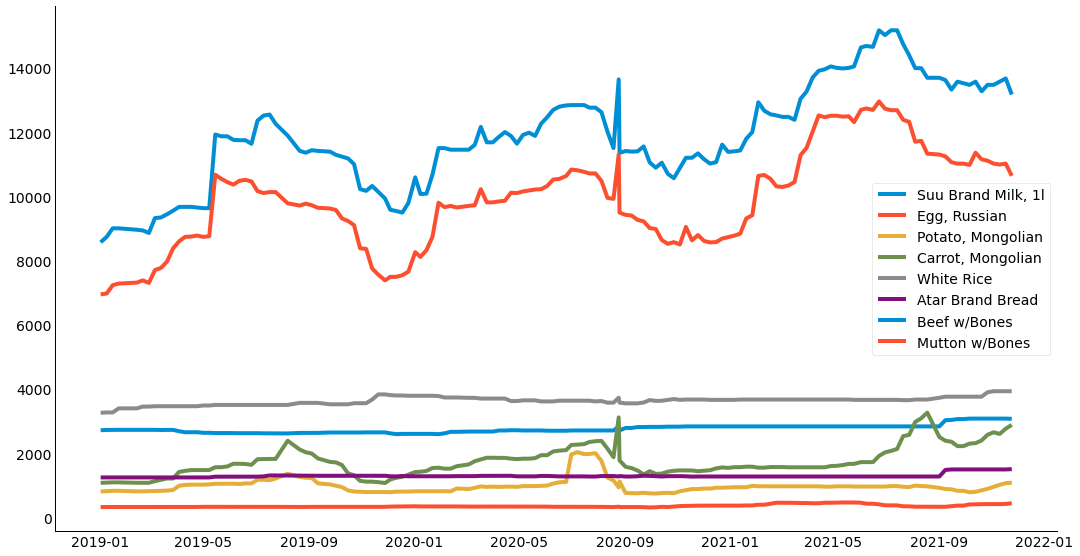

In [42]:
fig, ax = plt.subplots(figsize=(16,9))

avg_df = df[df['product'].isin(product_list)].groupby(by=['product', 'date']).mean().reset_index()
x = avg_df['date'].unique()

for product in product_list:
    ax.plot(x, avg_df[avg_df['product'] == product]['price'], label=product)
ax.legend()

In [43]:
product_list

['Suu Brand Milk, 1l',
 'Egg, Russian',
 'Potato, Mongolian',
 'Carrot, Mongolian',
 'White Rice',
 'Atar Brand Bread',
 'Beef w/Bones',
 'Mutton w/Bones']

In [49]:
datetime.date(2020,8,1)

datetime.date(2020, 8, 1)

(17897.0, 18959.0)

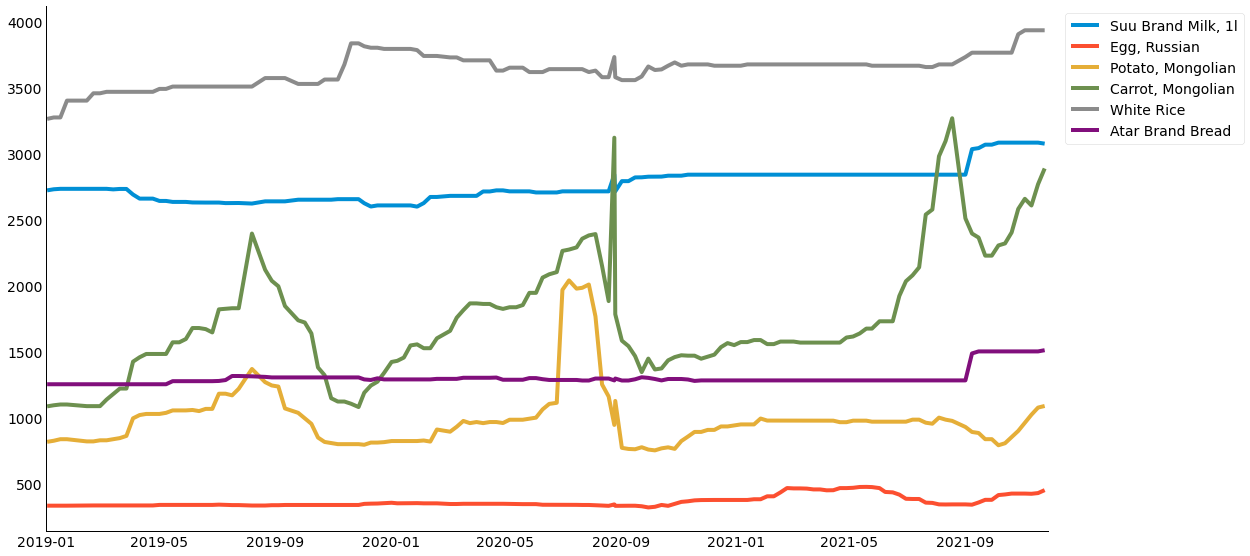

In [64]:
fig, ax = plt.subplots(figsize=(16,9))

sub_list = ['Suu Brand Milk, 1l',
 'Egg, Russian',
 'Potato, Mongolian',
 'Carrot, Mongolian',
 'White Rice',
 'Atar Brand Bread',]

avg_df = df[df['product'].isin(sub_list)].groupby(by=['product', 'date']).mean().reset_index()
x = avg_df['date'].unique()

for product in sub_list:
    ax.plot(x, avg_df[avg_df['product'] == product]['price'], label=product)
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_xlim(datetime.date(2019,1,1), datetime.date(2021,11,28))

## 3. Is there a sign of price anchoring?

In [71]:
df['thousands'] = df['price'] % 1000 == 0

In [72]:
df['hundreds'] = df['price'] % 100 == 0

In [76]:
df['tens'] = df['price'] % 10 == 0

In [77]:
df.head()

,date,product,market,size,price,thousands,hundreds,tens
0,2019-01-02,Aleika High Grade Flour,Bars,kg,NaN,False,False,False
1,2019-01-02,Mutton w/Bones,Max/M Mart,kg,6950.0,False,False,True
2,2019-01-02,Mutton w/Bones,Khuchit Shonkhor,kg,6500.0,False,True,True
3,2019-01-02,Mutton w/Bones,Kharkhorin,kg,6000.0,True,True,True
4,2019-01-02,Mutton w/Bones,Emart,kg,6900.0,False,True,True


In [81]:
df.groupby(by=['market']).sum()

,price,thousands,hundreds,tens
market,,,,
Bars,1.246198e+07,717,3802,4116
Bayanzurkh,1.500621e+07,887,4107,4372
Bumbugur,1.460550e+07,913,3789,4211
Emart,1.042408e+07,41,808,2831
Kharkhorin,1.545127e+07,839,4239,4548
Khuchit Shonkhor,1.564271e+07,803,4192,4537
Max/M Mart,1.084430e+07,143,929,3225
Mercury/Ikh Nayad,1.071177e+07,728,2468,2666
Nomin,1.173383e+07,13,135,511
